# Poisson Kriging Centroid-based approach

Before starting this tutorial, be sure that you have understood concepts in of ordinary kriging and semivariogram regularization.

The Poisson Kriging technique is used to model spatial count data. We analyze a particular case where values are counted over blocks, and those polygons have irregular shapes and sizes. We will predict the breast cancer rates in the Northeastern counties of the U.S. We use U.S. Census 2010 data to create point support for blocks.

Even if our areal data has polygons with irregular shapes and sizes, we can assume that each region may be represented by its centroid. This is a huge simplification; we can do it at our own risk. However, there are cases when we can use this method instead of the Area-to-Area Kriging. Those cases are:

- we need to perform fast and scalable calculations
- blocks are similar in shapes and sizes (e.g. blocks are hexagons, or rectangular shape)

- Centroid-based Poisson Kriging is much faster than Area-to-Area or Area-to-Point Poisson Kriging, and for some applications, it may be the desired property.

## Prerequisites

- **Domain**:
  - kriging
  - Poisson kriging and Poisson distribution
  - rates

- **Package**:
  - `Deconvolution()`
  - `ordinary_kriging()`
  - `TheoreticalVariogram()`

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Load regularized semivariogram model
3. Prepare data for Poisson Kriging
4. Filtering areas
5. Evaluate

## 1. Prepare data

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from tqdm import tqdm

from pyinterpolate import TheoreticalVariogram, Blocks, PointSupport, centroid_poisson_kriging

In [2]:
DATASET = '../data/blocks/cancer_data.gpkg'
OUTPUT = '../data/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
blocks = Blocks(
    ds=gpd.read_file(DATASET, layer=POLYGON_LAYER),
    value_column_name=POLYGON_VALUE,
    geometry_column_name=GEOMETRY_COL,
    index_column_name=POLYGON_ID
)

In [4]:
point_support = PointSupport(
    points=gpd.read_file(DATASET, layer=POPULATION_LAYER),
    blocks=blocks,
    points_value_column=POP10,
    points_geometry_column=GEOMETRY_COL,
    verbose=True
)

<Axes: >

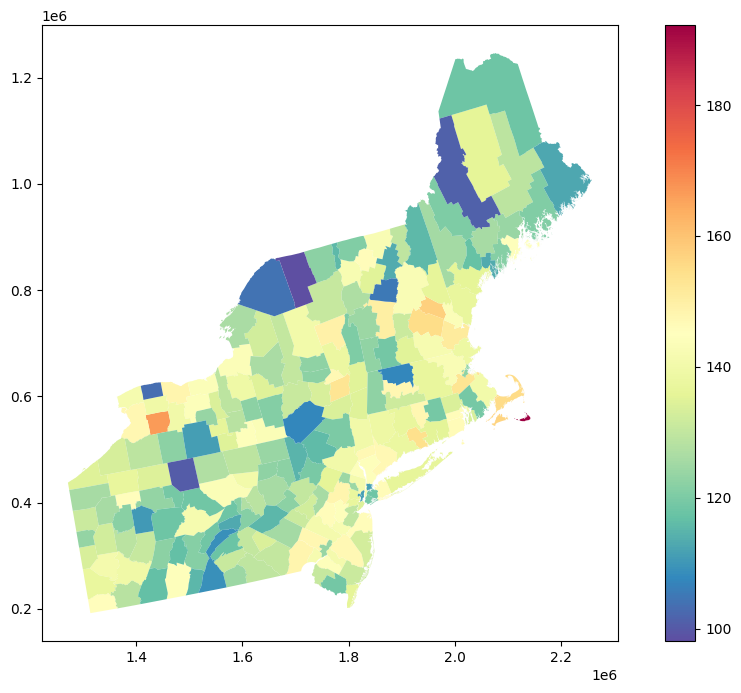

In [5]:
blocks.ds.plot(column=blocks.value_column_name,
               cmap='Spectral_r',
               legend=True,
               figsize=(12, 8))

**Clarification**: It is always a good idea to look into the spatial patterns in dataset and to visually check if our data do not have any `NaN` values. We use the geopandas `GeoDataFrame.plot()` function with a color map that diverges regions based on the cancer incidence rates. The output map is not ideal, and it has a few unreliable results, for example:

- In counties with a small population, where the ratio number of cases to population size is high even if the number of cases is low,
- Counties that are very big and sparsely populated may draw more of our attention than densely populated counties,
- Transitions of colors (rates) between counties may be too abrupt, even if we know that neighboring counties should have closer results.

We can overcome those problems using Centroid-based Poisson Kriging for filtering. But we must be aware that this method introduces a bias: each polygon falls into its centroid, but polygons' shapes and sizes differ, so centroid representation erases spatial patterns.

## 2. Load regularized semivariogram model

We load a regularized semivariogram from the tutorial about Semivariogram Regularization. You can always perform semivariogram regularization along with the Poisson Kriging, but it is a very long process, and it is more convenient to separate those two steps.

In [6]:
semivariogram = TheoreticalVariogram()

In [7]:
semivariogram.from_json(OUTPUT)

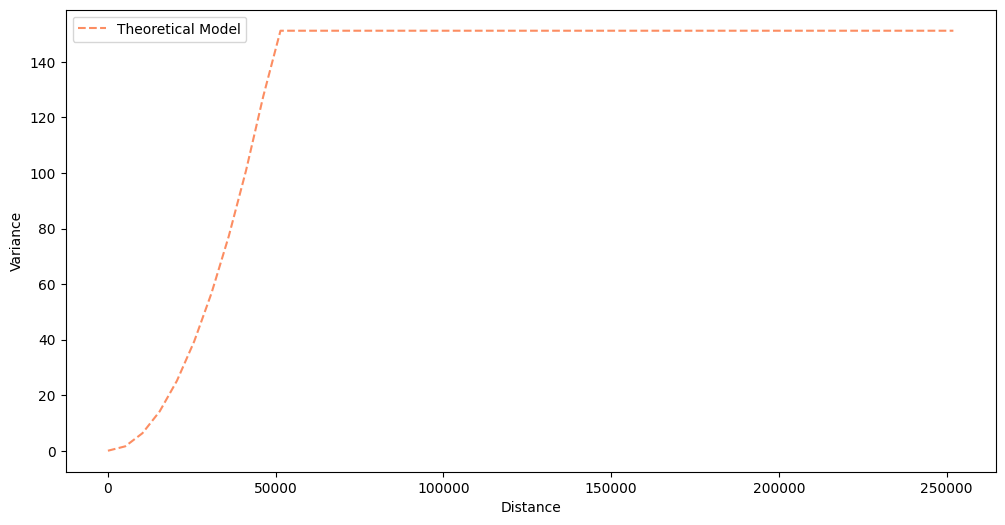

In [8]:
semivariogram.plot(experimental=False)

## 3. Prepare data for Poisson Kriging

We simply select random blocks values from blocks data and try to predict those values using Poisson Kriging.


In [9]:
sample_ids = blocks.ds.sample(20)['FIPS'].to_numpy()

In [10]:
sample_ids

array([33017, 23013, 42021, 50009, 36025, 34003, 34025, 42031, 36055,
       42063, 50005, 42121, 44003, 42013, 36081, 23015, 42089, 36077,
       36103, 42075])

## 4. Filtering areas

You may start to work with predictions with a fitted semivariogram model. Centroid-based Poisson Kriging takes five arguments during the run:

1. **semivariogram_model**: fitted semivariogram model
2. **point_support**: point support data
3. **unknown_block_index**: id of the interpolated block (`point_support` must have this block's point support coordinates and values)
4. **neighbors_range**: how wide is neighbors search area, by default it is `semivariogram_model` range
5. **number_of_neighbors**: how many neighbors are used for the interpolation

The algorithm in the cell below iteratively picks one area from the test set and performs prediction. Then, forecast bias, the difference between actual and predicted value, is calculated. Forecast Bias clarifies if our algorithm predictions are too low or too high (under- or overestimation). The following parameter is the Root Mean Squared Error. This measure tells us more about outliers and huge differences between predictions and actual values. We will see it in the last part of the tutorial.



In [11]:
preds = []

for b_id in tqdm(sample_ids):
    pred = centroid_poisson_kriging(
        semivariogram_model=semivariogram,
        point_support=point_support,
        unknown_block_index=b_id,
        neighbors_range=semivariogram.rang*2,
        number_of_neighbors=8,
        raise_when_negative_error=False,
        allow_lsa=False
    )
    preds.append(pred)

100%|██████████| 20/20 [00:00<00:00, 63.39it/s]


In [12]:
results = pd.DataFrame(preds)

In [13]:
results = results.merge(blocks.ds, left_on='block_id', right_on='FIPS')

In [14]:
results.head()

,block_id,zhat,sig,FIPS,rate,geometry,representative_points,lon,lat
0,33017,146.378349,7.289906,33017,143.4,"MULTIPOLYGON (((2014119.389 731934.664, 201410...",POINT (1995273.14 751082.633),1.995273e+06,751082.632906
1,23013,124.184891,6.320333,23013,144.3,"MULTIPOLYGON (((2119901.537 891937.097, 211985...",POINT (2111953.438 883662.3),2.111953e+06,883662.300074
2,42021,124.771916,6.669672,42021,122.0,"MULTIPOLYGON (((1443204.664 274131.922, 144314...",POINT (1449075.533 303353.927),1.449076e+06,303353.927032
3,50009,123.782533,5.449596,50009,129.5,"MULTIPOLYGON (((1880445.054 894660.638, 188044...",POINT (1898429.933 888701.931),1.898430e+06,888701.931267
4,36025,126.825975,NaN,36025,107.4,"POLYGON ((1686399.039 564067.714, 1686411.693 ...",POINT (1714888.154 552705.062),1.714888e+06,552705.061964


## 5. Evaluate

The analysis of errors is the last analysis step. We plot two histograms: forecast bias and squared error then we calculate the base statistics of a dataset.

In [15]:
results['forecast_bias'] = results['zhat'] - results['rate']
results['squared_error'] = (results['rate'] - results['zhat'])**2

<Axes: ylabel='Frequency'>

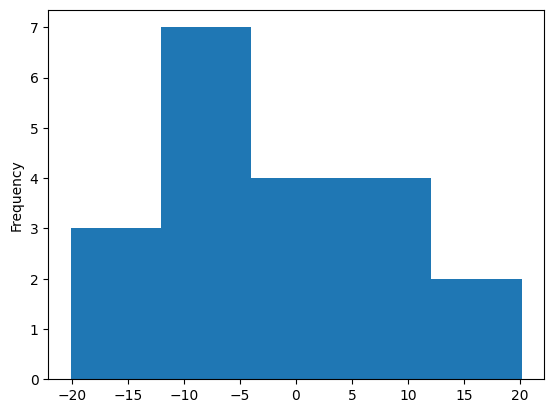

In [16]:
results['forecast_bias'].plot(kind='hist', bins=5)

<Axes: ylabel='Frequency'>

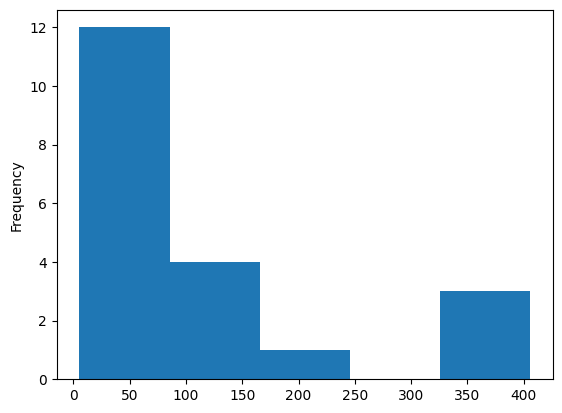

In [17]:
results['squared_error'].plot(kind='hist', bins=5)

In [18]:
results[['zhat', 'rate', 'forecast_bias', 'squared_error']].describe()

,zhat,rate,forecast_bias,squared_error
count,20.000000,20.000000,20.000000,20.000000
mean,129.550448,130.385000,-0.834552,112.987774
std,6.006058,12.004792,10.872045,133.941210
min,122.676038,107.400000,-20.115109,5.529781
25%,125.279056,121.675000,-8.177585,25.502338
50%,127.981213,130.450000,-1.450174,53.632457
75%,133.598187,141.450000,5.070950,143.007544
max,146.378349,148.400000,20.145009,405.821373


In [19]:
rmse = np.sqrt(np.mean(results['squared_error']))
print(rmse)

10.629570728151343


**Clarification**: Analysis of Forecast Bias and Root Mean Squared Error. Their distribution and basic properties are describing model performance. However, consider that the table above is a single test case (realization) and can be misleading. The good idea is to repeat the test dozens of times with a different training/test set division each time. After this, we average results from multiple tests and get insight into our model's behavior.

- negative forecast bias: model underestimates predictions
- positive forecast bias: model overestimates predictions
- forecast bias close to 0: model is (probably) accurate
- root mean squared error: accuracy measure, large rmse means that model performs poorly or we have many outliers

**Note 1**: Those results are not decisive. Our sample has been selected randomly, and there is a chance that it is not a spatially representative sample! (E.g., areas only from one region). The good idea is to repeat the experiment multiple times with other samples and average results to determine how well the model performs.

**Note 2**: If we analyze errors’ statistics, we should consider not only error's mean value. Let’s look at different pieces of information:

- Histograms clearly show us how dispersed and grouped errors are, and most importantly, we directly see the worst predictions and how many of them are generated by our model.
- What is plotted on a histogram is described by statistics. We may check the max and the min error, but the true power comes when we analyze quartiles and standard deviation.
- The standard deviation is a good measurement of our model’s variance; lower standard deviation of errors, the better.
- Sometimes, we must look into quartiles. A very high mean but relatively low median (or even the 3rd quartile) indicates that we have only a few wrong predictions (that could be interesting, because it means that few locations are heavily under- or over-estimated).


## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-28 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |